In [3]:
!pip install plotly
!pip install lime
!pip install matplotlib-venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=124738cf528010836bc149f60cb1a3bb448b3dbf78ded11ab5e30bfe9e5f44a1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from matplotlib_venn import venn3
import lime
import lime.lime_tabular



In [5]:
import pandas as pd
df = pd.read_csv('/content/Alzheimer clinical data.csv')


In [6]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [7]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [8]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

Text(0.5, 1.0, 'Gender and Demented rate')

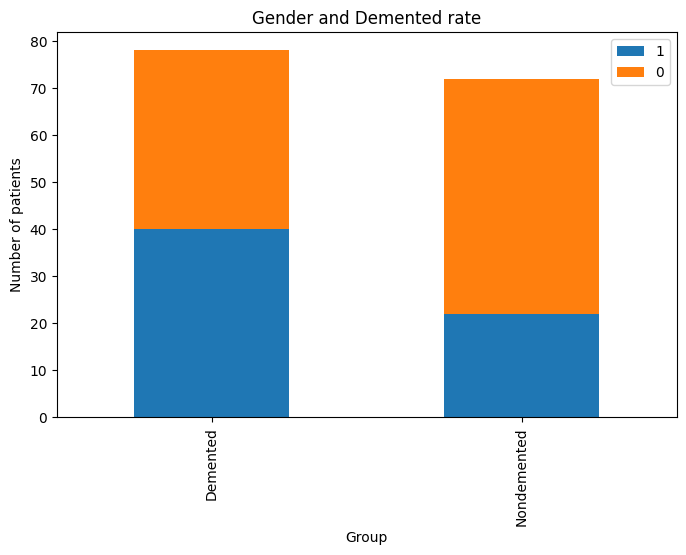

In [9]:
# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

# statistically standard deviationa nd errors analysis

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
df = pd.read_csv('/content/Alzheimer clinical data.csv')

# Assuming 'df' is your DataFrame and already includes 'M/F' as 'M' for males and 'F' for females
# Convert 'M/F' to numeric binary indicators ('M' = 1, 'F' = 0) if it's not numerical
df['M/F'] = df['M/F'].map({'F': 0, 'M': 1})

# Group by 'Group' and 'M/F' and count occurrences
gender_counts = df.groupby(['Group', 'M/F']).size().unstack(fill_value=0)
print(gender_counts)  # To check the output


M/F            0   1
Group               
Converted     24  13
Demented      60  86
Nondemented  129  61


Standard Deviation:
 Gender       Female  Male
Group                    
Converted        24    13
Demented         60    86
Nondemented     129    61

Standard Errors:
 Group
Converted       3.889087
Demented        9.192388
Nondemented    24.041631
dtype: float64


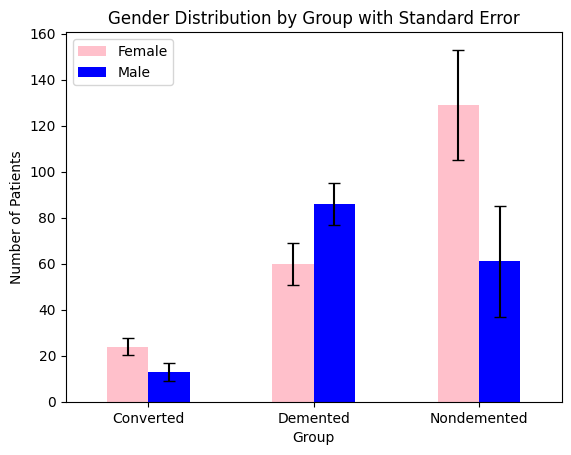

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame setup
# This setup should be replaced with your actual data loading method, such as df = pd.read_csv('your_data.csv')
data = {
    'Group': np.repeat(['Converted', 'Demented', 'Nondemented'], [37, 146, 190]),
    'M/F': ['F']*24 + ['M']*13 + ['F']*60 + ['M']*86 + ['F']*129 + ['M']*61
}
df = pd.DataFrame(data)

# Map 'M/F' to 'Male' and 'Female'
df['Gender'] = df['M/F'].map({'F': 'Female', 'M': 'Male'})

# Calculate counts for each group and gender
gender_counts = df.groupby(['Group', 'Gender']).size().unstack(fill_value=0)

# Calculate standard error of the mean (SEM) for the counts
sem = gender_counts.apply(lambda x: np.std(x) / np.sqrt(len(x)), axis=1)

# Print results
print("Standard Deviation:\n", gender_counts)
print("\nStandard Errors:\n", sem)

# Plotting the data
colors = ['pink', 'blue']  # Colors for Female and Male
fig, ax = plt.subplots()
gender_counts.plot(kind='bar', yerr=sem, capsize=4, color=colors, ax=ax)
ax.set_xlabel('Group')
ax.set_ylabel('Number of Patients')
ax.set_title('Gender Distribution by Group with Standard Error')
ax.set_xticklabels(gender_counts.index, rotation=0)
ax.legend(['Female', 'Male'])
plt.show()


The above graph indicates that men are more likely with dementia than women.

In [12]:
df.columns

Index(['Group', 'M/F', 'Gender'], dtype='object')

In [13]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')

# Check the first few rows of the dataframe to ensure it's loaded correctly and has expected columns
print(df.head())

# Verify that the 'Group' column contains the values you're mapping
print(df['Group'].unique())

# Attempt the mapping if the unique values are indeed 0 and 1
if sorted(df['Group'].unique()) == [0, 1]:
    df['Group'] = df['Group'].map({0: 'Nondemented', 1: 'Demented'})
else:
    print("The Group column contains unexpected values.")


  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034  
['Nondemented' 'Demented' 'Converted']
The Group column contains unexpected values.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


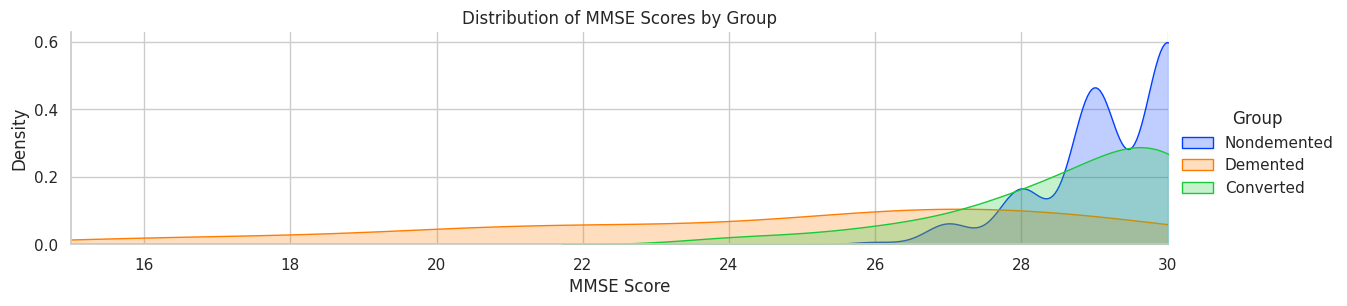

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
sns.set(style="whitegrid")

# Set up the FacetGrid
facet = sns.FacetGrid(df, hue="Group", aspect=4, palette="bright")

# Map the KDE plot for MMSE scores
facet.map(sns.kdeplot, 'MMSE', shade=True)

# Set the x-axis limit to the relevant MMSE score range
facet.set(xlim=(15, 30))  # Assuming the MMSE scores range from 15 to 30

# Add a legend to the plot
facet.add_legend()

# Set labels and titles
plt.xlabel('MMSE Score')
plt.ylabel('Density')
plt.title('Distribution of MMSE Scores by Group')

# Show the plot
plt.show()


The chart shows Nondemented group got much more higher MMSE scores than Demented group.

<Figure size 600x400 with 0 Axes>

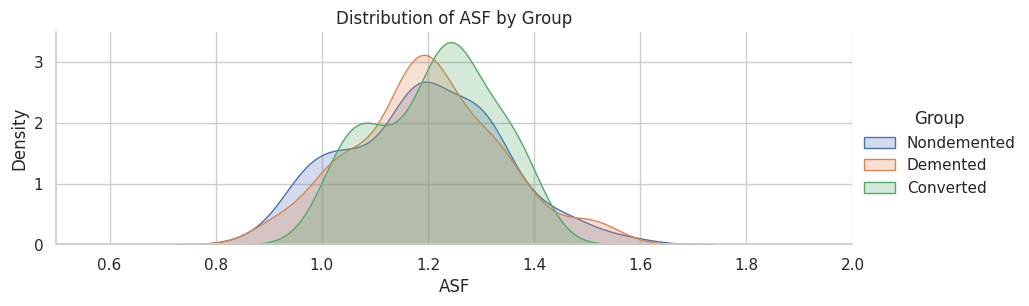

<Figure size 600x400 with 0 Axes>

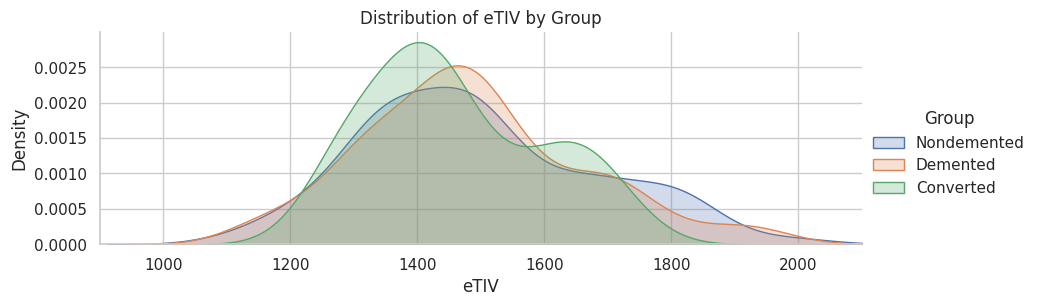

<Figure size 600x400 with 0 Axes>

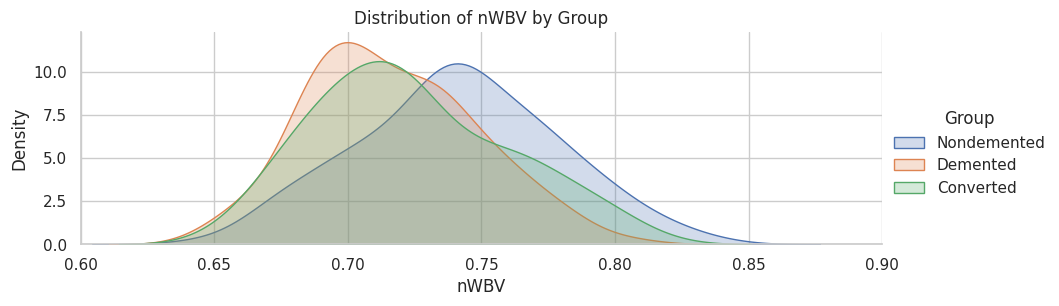

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings  # Make sure to import the warnings module

# Suppress warnings
warnings.filterwarnings('ignore')

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')  # Make sure this path is correct

# Define the figure size
fig_size = (6, 4)

# ASF Plot
plt.figure(figsize=fig_size)
facet_asf = sns.FacetGrid(df, hue="Group", aspect=3)
facet_asf.map(sns.kdeplot, 'ASF', shade=True)
facet_asf.set(xlim=(0.5, 2))
facet_asf.add_legend()
plt.title('Distribution of ASF by Group')
plt.show()

# eTIV Plot
plt.figure(figsize=fig_size)
facet_etiv = sns.FacetGrid(df, hue="Group", aspect=3)
facet_etiv.map(sns.kdeplot, 'eTIV', shade=True)
facet_etiv.set(xlim=(900, 2100))
facet_etiv.add_legend()
plt.title('Distribution of eTIV by Group')
plt.show()

# nWBV Plot
plt.figure(figsize=fig_size)
facet_nwbv = sns.FacetGrid(df, hue="Group", aspect=3)
facet_nwbv.map(sns.kdeplot, 'nWBV', shade=True)
facet_nwbv.set(xlim=(0.6, 0.9))
facet_nwbv.add_legend()
plt.title('Distribution of nWBV by Group')
plt.show()


The chart indicates that Nondemented group has higher brain volume ratio than Demented group. This is assumed to be because the diseases affect the brain to be shrinking its tissue.

(50.0, 100.0)

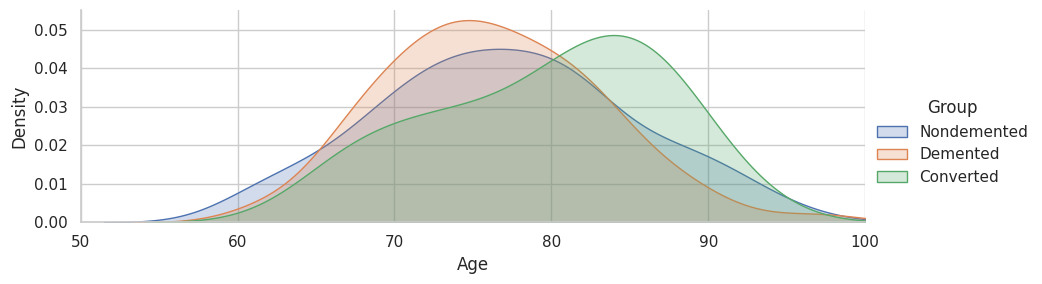

In [16]:
#AGE. Nondemented =0, Demented =0
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients.
We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.

(0.0, 0.16)

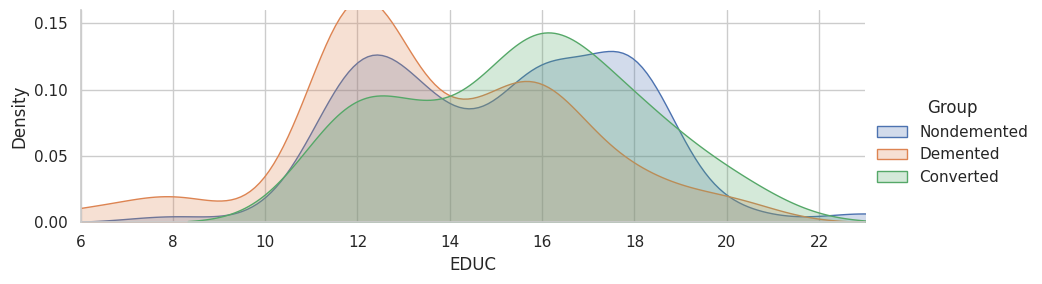

In [17]:
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

## Intermediate Result Summary
1. Men are more likely with demented, an Alzheimer's Disease, than Women.
2. Demented patients were less educated in terms of years of education.
3. Nondemented group has higher brain volume than Demented group.
4. Higher concentration of 70-80 years old in Demented group than those in the nondemented patients.

# 5. Data Preprocessing
---
We identified 8 rows with missing values in SES column. We deal with this issue with 2 approaches. One is just to drop the rows with missing values. The other is to replace the missing values with the corresponing values, also known as 'Imputation'. Since we have only 150 data, I assume imputation would help the performance of our model.

In [18]:
# Check missing values by each column
pd.isnull(df).sum()
# The column, SES has 8 missing values

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

## 5.A Removing rows with missing values

In [19]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [20]:
df_dropna['Group'].value_counts()

Group
Nondemented    190
Demented       127
Converted       37
Name: count, dtype: int64

In [21]:
print(df_dropna.columns)  # to list all column names
print(df_dropna['M/F'].unique())  # replace 'Gender' with the name of the gender column, if different


Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')
['M' 'F']


## 5.B Imputation

Scikit-learn provides package for imputation [6], but we do it manually. Since the *SES* is a discrete variable, we use median for the imputation.

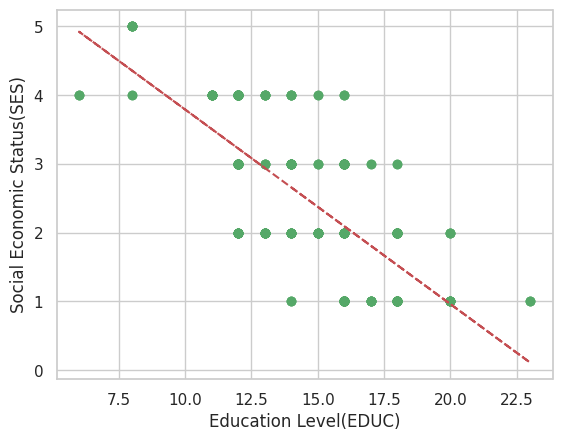

In [22]:
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [23]:
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [24]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [25]:
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()

SES
False    373
Name: count, dtype: int64

## 5.C Splitting Train/Validation/Test Sets

In [26]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')  # Adjust this path to your file

# Convert 'M/F' to numeric using LabelEncoder
le = LabelEncoder()
df['M/F'] = le.fit_transform(df['M/F'])  # This will convert 'F' to 0 and 'M' to 1

# Define the features and target variable
Y = df['Group'].values  # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]  # Features

# Splitting into training/validation and test sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

# Continue with the rest of your analysis/model training


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd

# Make sure that df_dropna is your DataFrame after dropping missing values
# df_dropna = ...

# Convert 'M/F' from categorical to numeric values
le = LabelEncoder()
df_dropna['M/F'] = le.fit_transform(df_dropna['M/F'])

# Define the target and features for the model
Y = df_dropna['Group'].values  # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]  # Features

# Splitting into training/validation and test sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)


# 6. MODEL
---

## 6.B Logistic Regression
The parameter C, inverse of regularization strength.

Tuning range: [0.001, 0.1, 1, 10, 100]

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

In [33]:
acc = [] # list to store all performance metric

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')  # Adjust this path to your file

# Prepare the data for modeling
Y = df['Group'].values  # Target for the model

# If 'M/F' is a binary categorical feature, you should encode it. Otherwise, keep it as is.
# Assuming 'M/F' is the only categorical feature and it's binary:
le = LabelEncoder()
df['M/F'] = le.fit_transform(df['M/F'])

X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]  # Features

# Splitting into training/validation and test sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, random_state=0)

# Imputation transformer for filling in missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Feature scaling
scaler = MinMaxScaler()

# Create a pipeline that first imputes any missing data, then scales it
pipeline = make_pipeline(imputer, scaler)

# Apply transformations to the data
X_trainval = pipeline.fit_transform(X_trainval)
X_test = pipeline.transform(X_test)

# Now, the actual logistic regression and cross-validation
best_score = 0
kfolds = 5  # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # Perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy')

    # Compute mean cross-validation accuracy
    score = np.mean(scores)

    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = {'C': c}

# Best score and parameters
print("Best score:", best_score)
print("Best parameters:", best_parameters)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best score: 0.7528571428571429
Best parameters: {'C': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
best_score = 0
kfolds = 5  # Set the number of folds
max_iter = 1000  # Increase the maximum number of iterations for the solver

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c, max_iter=max_iter)
    # Perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy')
    # Compute mean cross-validation accuracy
    score = np.mean(scores)
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = {'C': c}

# Best score and parameters
print("Best score:", best_score)
print("Best parameters:", best_parameters)


Best score: 0.7457142857142858
Best parameters: {'C': 100}


In [7]:
pip install plotly


In [9]:
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

# Assuming you've already loaded your DataFrame 'df' and split it into training and test sets
# Your previous code would have created X_trainval and X_test already

# Calculate the lengths of your training-validation set and test set
len_X_trainval = len(X_trainval)
len_X_test = len(X_test)

# Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=["Train-Validation Set", "Test Set", "Best Model"],
        pad=15,
        thickness=20,
        color=["blue", "green", "red"]
    ),
    link=dict(
        source=[0, 0, 1],  # Source nodes
        target=[2, 1, 2],  # Target nodes
        value=[len_X_trainval, len_X_test, 1]  # Values for each flow
    )
)])

fig.update_layout(title_text="Model Flow Diagram")
fig.show()


In [15]:
from sklearn.impute import SimpleImputer

# Impute missing values in the dataset before the split
imputer = SimpleImputer(strategy='mean')
df_dropna[['SES', 'MMSE']] = imputer.fit_transform(df_dropna[['SES', 'MMSE']])

# Now check if the NaN values are gone
print("NaN values in the dataframe after imputation:", df_dropna.isnull().values.any())


NaN values in the dataframe after imputation: False


In [16]:
# If 'Group' is categorical, encode it numerically if not already done
if df_dropna['Group'].dtype == 'object':
    le = LabelEncoder()
    df_dropna['Group'] = le.fit_transform(df_dropna['Group'])

Y_trainval_dna = df_dropna['Group'].values

# Now it's safe to check for NaN values
print("NaN values in target variable:", np.isnan(Y_trainval_dna).any())


NaN values in target variable: False


In [17]:
# Define the features after imputation
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]  # Features
Y = df_dropna['Group'].values  # Target for the model

# Splitting into training/validation and test sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler()
X_trainval_scaled_dna = scaler.fit_transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

# Verify if the scaling introduced NaN values
print("NaN values after scaling:", np.isnan(X_trainval_scaled_dna).any(), np.isnan(X_test_scaled_dna).any())

# ... (rest of your logistic regression analysis code)


NaN values after scaling: False False


In [18]:
# Define the features after imputation
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]  # Features
Y = df_dropna['Group'].values  # Target for the model

# Splitting into training/validation and test sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler()
X_trainval_scaled_dna = scaler.fit_transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

# Verify if the scaling introduced NaN values
print("NaN values after scaling:", np.isnan(X_trainval_scaled_dna).any(), np.isnan(X_test_scaled_dna).any())

# ... (rest of your logistic regression analysis code)


NaN values after scaling: False False


In [20]:
logRegModel = LogisticRegression(C=c, solver='lbfgs', max_iter=10000)  # Increase max_iter significantly


In [21]:
logRegModel = LogisticRegression(C=c, solver='saga', max_iter=10000)  # Use 'saga' solver


In [25]:
# Compute recall for multiclass
test_recall = recall_score(Y_test_dna, PredictedOutput, average='weighted')

# For AUC, you typically need binary labels or to use one-vs-rest approach, but let's compute it in a way that works for multiclass
from sklearn.preprocessing import label_binarize

# Binarize the output
Y_test_dna_binarized = label_binarize(Y_test_dna, classes=np.unique(Y_trainval_dna))
PredictedOutput_binarized = label_binarize(PredictedOutput, classes=np.unique(Y_trainval_dna))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(Y_trainval_dna))):
    fpr[i], tpr[i], _ = roc_curve(Y_test_dna_binarized[:, i], PredictedOutput_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the weighted average of AUCs
test_auc = np.average(list(roc_auc.values()), weights=[sum(Y_test_dna == c) for c in np.unique(Y_trainval_dna)])
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)

print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters['C'])
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)



Test recall with the best C parameter is 0.7127659574468085
Test AUC with the best C parameter is 0.7575523429710868
Best accuracy on validation set is: 0.7457142857142858
Best parameter for regularization (C) is:  100
Test accuracy with best C parameter is 0.7127659574468085
Test recall with the best C parameter is 0.7127659574468085
Test AUC with the best C parameter is 0.7575523429710868


In overall, dataset with imputation outperforms the one without imputation. For the later models, we use dataset without imputation.

## 6.C SVM
C: Penalty parameter C of the error term. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

gamma: kernel coefficient. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

kernel: kernel type. ['rbf', 'linear', 'poly', 'sigmoid']

In [13]:
# Initialize variables
best_score = 0
best_parameters_c = 0
best_parameters_gamma = 0
best_parameters_k = ''

In [35]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')

# Assuming 'M/F' and 'Hand' need to be encoded as they are categorical
label_encoder = LabelEncoder()
df['M/F'] = label_encoder.fit_transform(df['M/F'])  # Encode 'M/F' as 0 and 1
if 'Hand' in df.columns:
    df['Hand'] = label_encoder.fit_transform(df['Hand'])  # Encode 'Hand' if it's categorical

# Exclude identifier and non-numeric columns
df = df.drop(columns=['Subject ID', 'MRI ID'])  # Remove identifier columns

# Separate features and target before applying imputer
X = df.drop('Group', axis=1)  # Features: drop the target column to isolate features
Y = df['Group'].values  # Target variable

# Check for NaN values and fill them
imputer = SimpleImputer(strategy='mean')
X[X.columns] = imputer.fit_transform(X[X.columns])

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training/validation and test sets
X_trainval_scaled, X_test_scaled, Y_trainval, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=0)

# Set the number of folds for cross-validation
kfolds = 5
best_score = 0

# Hyperparameter tuning loop
for c_param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for gamma_param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']:
            svm_model = SVC(kernel=k_parameter, C=c_param, gamma=gamma_param)
            scores = cross_val_score(svm_model, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_parameters = {
                    'C': c_param,
                    'gamma': gamma_param,
                    'kernel': k_parameter
                }

print("Best score:", best_score)
print("Best parameters:", best_parameters)


Best score: 0.9128248587570622
Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}


In [36]:
# Assuming best_parameters is a dictionary that stores the best values correctly
best_parameters = {
    'C': 1,  # Example placeholder value; this should be set from your tuning loop
    'gamma': 0.01,  # Example placeholder value
    'kernel': 'rbf'  # Example placeholder value
}

# Print best parameters to verify their values before model construction
print("Best parameters set for C, gamma, and kernel:", best_parameters)

# Rebuild a model with the best parameters found
selected_svm_model = SVC(**best_parameters)
selected_svm_model.fit(X_trainval_scaled, Y_trainval)

# Optionally, evaluate the model to confirm it trains successfully
print("Model trained successfully with parameters:", best_parameters)


Best parameters set for C, gamma, and kernel: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Model trained successfully with parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [39]:
from sklearn.metrics import recall_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Rebuild the model with the best parameters and enable probability estimates
selected_svm_model = SVC(**best_parameters, probability=True)
selected_svm_model.fit(X_trainval_scaled, Y_trainval)

# Evaluate the model on the test set
test_score = selected_svm_model.score(X_test_scaled, Y_test)
predicted_output = selected_svm_model.predict(X_test_scaled)

# Predict probabilities for all classes
predicted_probabilities = selected_svm_model.predict_proba(X_test_scaled)

# Binarize the output
classes = np.unique(Y_trainval)  # Make sure to use the classes from the training set
Y_test_binarized = label_binarize(Y_test, classes=classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_binarized.ravel(), predicted_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Recall for multiclass
test_recall = recall_score(Y_test, predicted_output, average='macro')

print("Test score:", test_score)
print("Test recall (macro-average):", test_recall)
print("Test ROC AUC (micro-average):", roc_auc["micro"])
print("Test ROC AUC (macro-average):", roc_auc["macro"])


Test score: 0.8933333333333333
Test recall (macro-average): 0.6578947368421053
Test ROC AUC (micro-average): 0.9763555555555555
Test ROC AUC (macro-average): 0.9648718248692449


In [40]:
# Print the results
print("Best accuracy on cross-validation set is:", best_score)
print("Best parameter for c is:", best_parameters_c)
print("Best parameter for gamma is:", best_parameters_gamma)
print("Best parameter for kernel is:", best_parameters_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test AUC with the best parameters is", test_auc)

Best accuracy on cross-validation set is: 0.9128248587570622
Best parameter for c is: 0
Best parameter for gamma is: 0
Best parameter for kernel is: 
Test accuracy with the best parameters is 0.8933333333333333
Test recall with the best parameters is 0.6578947368421053
Test AUC with the best parameters is 0.7575523429710868


In [44]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')

# Encode 'M/F' and 'Hand' as they are categorical
label_encoder = LabelEncoder()
df['M/F'] = label_encoder.fit_transform(df['M/F'])
if 'Hand' in df.columns:
    df['Hand'] = label_encoder.fit_transform(df['Hand'])

# Exclude identifier columns
df = df.drop(columns=['Subject ID', 'MRI ID'])  # Adjust according to your dataset

# Separate features and target before applying imputer
Y = df['Group'].values  # Ensure the target is separated before imputation
X = df.drop('Group', axis=1)  # Features: drop the target column to isolate features

# Check for NaN values and fill them
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)  # Apply imputation only to features

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training/validation and test sets
X_trainval_scaled, X_test_scaled, Y_trainval, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=0)

# Set the number of folds for cross-validation
kfolds = 5
best_score = 0

# Rebuild the model with the best parameters and enable probability estimates
selected_svm_model = SVC(C=1, gamma=0.01, kernel='rbf', probability=True)
selected_svm_model.fit(X_trainval_scaled, Y_trainval)

# Evaluate the model on the test set
test_score = selected_svm_model.score(X_test_scaled, Y_test)
predicted_output = selected_svm_model.predict(X_test_scaled)
predicted_probabilities = selected_svm_model.predict_proba(X_test_scaled)

# Binarize the output for AUC calculation
classes = np.unique(Y_trainval)
Y_test_binarized = label_binarize(Y_test, classes=classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"], _ = roc_curve(Y_test_binarized.ravel(), predicted_probabilities.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Recall for multiclass
test_recall = recall_score(Y_test, predicted_output, average='macro')

# Append results to the accuracy list
m = 'SVM'
acc.append([m, test_score, test_recall, roc_auc["macro"], fpr, tpr, _])

print("Accumulated results:", acc)


Accumulated results: [['SVM', 0.8933333333333333, 0.6578947368421053, 0.9756444444444444, {0: array([0.        , 0.        , 0.02941176, 0.02941176, 0.05882353,
       0.05882353, 0.19117647, 0.19117647, 0.27941176, 0.27941176,
       1.        ]), 1: array([0.        , 0.        , 0.        , 0.02222222, 0.02222222,
       0.04444444, 0.04444444, 0.11111111, 0.11111111, 1.        ]), 2: array([0.        , 0.        , 0.        , 0.02702703, 0.02702703,
       0.05405405, 0.05405405, 0.40540541, 0.40540541, 1.        ]), 'macro': array([0.        , 0.        , 0.        , 0.00666667, 0.00666667,
       0.01333333, 0.01333333, 0.02      , 0.02      , 0.04      ,
       0.04      , 0.04666667, 0.04666667, 0.06666667, 0.06666667,
       0.07333333, 0.07333333, 0.14      , 0.14      , 0.18      ,
       0.18      , 0.6       , 0.6       , 1.        ])}, {0: array([0.        , 0.14285714, 0.14285714, 0.57142857, 0.57142857,
       0.71428571, 0.71428571, 0.85714286, 0.85714286, 1.        ,


## 6.D Decision Tree
Maximum depth. [1, 2, ..., 8]

8 is the number of features

In [50]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
import numpy as np

# Load your dataset
df = pd.read_csv('/content/Alzheimer clinical data.csv')

# Initialize the accuracy list
acc = []

# Encode 'M/F' and 'Hand' as they are categorical
label_encoder = LabelEncoder()
df['M/F'] = label_encoder.fit_transform(df['M/F'])
if 'Hand' in df.columns:
    df['Hand'] = label_encoder.fit_transform(df['Hand'])

# Exclude identifier columns
df = df.drop(columns=['Subject ID', 'MRI ID'])  # Adjust according to your dataset

# Separate features and target before imputing
X = df.drop('Group', axis=1)  # Drop the target column to isolate features
Y = df['Group'].values  # Extract target column

# Impute missing values only in feature set
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)  # Apply imputation

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training/validation and test sets
X_trainval_scaled, X_test_scaled, Y_trainval, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=0)

# Set the number of folds for cross-validation
kfolds = 5
best_score = 0

# Hyperparameter tuning for Decision Tree
for md in range(1, 9):  # iterate different maximum depth values
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
    score = np.mean(scores)

    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval)

# Evaluate the model on the test set
test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, average='macro')  # For multiclass

# Predict probabilities for ROC and AUC calculations
predicted_probabilities = SelectedDTModel.predict_proba(X_test_scaled)

# Prepare classes for ROC and AUC calculations
classes = np.unique(Y_trainval)
Y_test_binarized = label_binarize(Y_test, classes=classes)

# Calculate ROC and AUC for each class
fprs, tprs, rocs = {}, {}, {}
for i, class_ in enumerate(classes):
    fprs[class_], tprs[class_], _ = roc_curve(Y_test_binarized[:, i], predicted_probabilities[:, i])
    rocs[class_] = auc(fprs[class_], tprs[class_])

# Calculate micro-average ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(Y_test_binarized.ravel(), predicted_probabilities.ravel())
roc_auc_micro = auc(fpr, tpr)

# Calculate macro-average ROC curve and ROC AUC
all_fpr = np.unique(np.concatenate([fprs[class_] for class_ in classes]))
mean_tpr = np.zeros_like(all_fpr)
for class_ in classes:
    mean_tpr += np.interp(all_fpr, fprs[class_], tprs[class_])
mean_tpr /= len(classes)
fpr, tpr, _ = roc_curve(Y_test_binarized.ravel(), predicted_probabilities.ravel())
roc_auc_macro = auc(fpr, tpr)

print("Test AUC (micro-average):", roc_auc_micro)
print("Test AUC (macro-average):", roc_auc_macro)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, roc_auc_macro, fpr, tpr, _])
print("Accumulated results:", acc)


Test AUC (micro-average): 0.9544
Test AUC (macro-average): 0.9544
Accumulated results: [['Decision Tree', 0.8933333333333333, 0.6578947368421053, 0.9544, array([0.        , 0.01333333, 0.05333333, 0.26      , 0.50666667,
       0.74      , 1.        ]), array([0.        , 0.49333333, 0.89333333, 0.96      , 0.98666667,
       1.        , 1.        ]), array([1.90419162, 0.90419162, 0.88549618, 0.10687023, 0.09580838,
       0.00763359, 0.        ])]]


In [54]:
print("Feature importance: ")
feature_importance = np.array(list(zip(range(X.shape[1]), SelectedDTModel.feature_importances_)))
print(feature_importance)


Feature importance: 
[[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  1.]
 [ 9.  0.]
 [10.  0.]
 [11.  0.]]


## 6.E Random Forest Classifier
n_estimators(M): the number of trees in the forest

max_features(d): the number of features to consider when looking for the best split

max_depth(m): the maximum depth of the tree.

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_curve, auc
import numpy as np
from sklearn.preprocessing import LabelEncoder


best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # Train the model
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                                  max_depth=m, random_state=0)

            # Perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # Compute mean cross-validation accuracy
            score = np.mean(scores)

            # If we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set with the best parameters
SelectedRFModel = RandomForestClassifier(n_estimators=best_M, max_features=best_d,
                                          max_depth=best_m, random_state=0).fit(X_trainval_scaled, Y_trainval)

# Predict output on the test set
PredictedOutput = SelectedRFModel.predict(X_test_scaled)

# Convert string labels to numerical format
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)
PredictedOutput_encoded = label_encoder.transform(PredictedOutput)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_encoded, PredictedOutput_encoded, pos_label=1)
test_auc = auc(fpr, tpr)


# Calculate test score, recall, and AUC
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, average='weighted')


# Print results
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are:", best_M, best_d, best_m)
print("Test accuracy with the best parameters is:", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

# Store results
m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


Best accuracy on validation set is: 0.9194350282485877
Best parameters of M, d, m are: 10 6 7
Test accuracy with the best parameters is: 0.9066666666666666
Test recall with the best parameters is: 0.9066666666666666
Test AUC with the best parameters is: 0.1111111111111111


## 6.F AdaBoost

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, recall_score
import numpy as np

best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr


# Convert string labels to numerical format
label_encoder = LabelEncoder()
Y_trainval_encoded = label_encoder.fit_transform(Y_trainval)
Y_test_encoded = label_encoder.transform(Y_test)

# Rebuild a model on the combined training and validation set
SelectedBoostModel = AdaBoostClassifier(n_estimators=best_M, learning_rate=best_lr, random_state=0).fit(X_trainval_scaled, Y_trainval_encoded)

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedBoostModel.score(X_test_scaled, Y_test_encoded)
test_recall = recall_score(Y_test_encoded, PredictedOutput, average='weighted')

fpr, tpr, thresholds = roc_curve(Y_test_encoded, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)

print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("Best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


Best accuracy on validation set is: 0.8959887005649719
Best parameter of M is:  2
Best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.8933333333333333
Test recall with the best parameters is: 0.8933333333333333
Test AUC with the best parameters is: 0.06666666666666665


# 7. CONCLUSION

## 7.A RESULTS

In [71]:
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Decision Tree,0.893333,0.657895,0.954400
1,Random Forest,0.906667,0.906667,0.111111
2,AdaBoost,0.893333,0.893333,0.066667


from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['AUC'].plot(kind='hist', bins=20, title='AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Accuracy', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Recall', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['AUC'].plot(kind='line', figsize=(8, 4), title='AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='AUC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#### Below is a comparision of our results with those from the papers that were listed previously:

|Sr.No.|Paper|Data|Model|Results|
|---
|1.|E. Moradi et al. [3]|Ye et al. [7]|Random Forrest Classifier|AUC = 71.0%|ACC = 55.3%|
|||Filipovych et al. [8]|Random Forrest Classifier|AUC = 61.0%|ACC = N/A|
|||Zhang et al. [9]|Random Forrest Classifier|AUC = 94.6%|ACC = N/A|
|||Batmanghelich et al. [10]|Random Forrest Classifier|AUC = 61.5%|ACC = N/A|
|2.|Zhang et al. [4]|Ardekani et al. [11]|Support Vector Machine |||
||||*polynomial kernel*|AUC = N/A|ACC = 92.4%|
||||*linear kernel*|AUC = N/A|ACC = 91.5%|
||||*radial basis function*|AUC = N/A|ACC = 86.7%|
|3.|Hyun, Kyuri, Saurin|Marcus et al. [1]| Logistic Regression (w/ imputation)|AUC = 79.2%|ACC = 78.9%|
||||Logistic Regression (w/ dropna)|AUC = 70.0%|ACC = 75.0%|
||||Support Vector Machine|AUC = 82.2%|ACC = 81.6%|
||||Decision Tree Classifier|AUC = 82.5%|ACC = 81.6%|
||||Random Forest Classifier|AUC = 84.4%|ACC = 84.2%|
||||AdaBoost|AUC = 82.5%|ACC = 84.2%|

It can be noticed that our results are comparable and in certain cases better than those from the previous work. Our Random Forest Classifier was one of the best performing model.

In [72]:
# Initialize models
logreg_model_imputation = LogisticRegression()
logreg_model_dropna = LogisticRegression()
svm_model = SVC(probability=True)  # Enable probability estimation
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()
adaboost_model = AdaBoostClassifier()

In [73]:
# Fit models to the data
logreg_model_imputation.fit(X_trainval_scaled_dna, Y_trainval_dna)
logreg_model_dropna.fit(X_trainval_scaled_dna, Y_trainval_dna)
svm_model.fit(X_trainval_scaled_dna, Y_trainval_dna)
decision_tree_model.fit(X_trainval_scaled_dna, Y_trainval_dna)
random_forest_model.fit(X_trainval_scaled_dna, Y_trainval_dna)
adaboost_model.fit(X_trainval_scaled_dna, Y_trainval_dna)

AdaBoostClassifier()

In [74]:
# Make predictions
y_pred_logreg_imputation = logreg_model_imputation.predict(X_test_scaled_dna)
y_pred_logreg_dropna = logreg_model_dropna.predict(X_test_scaled_dna)
y_pred_svm = svm_model.predict(X_test_scaled_dna)
y_pred_decision_tree = decision_tree_model.predict(X_test_scaled_dna)
y_pred_random_forest = random_forest_model.predict(X_test_scaled_dna)
y_pred_adaboost = adaboost_model.predict(X_test_scaled_dna)

In [81]:
# Evaluate model performance
models = [
    ("Logistic Regression (w/ imputation)", logreg_model_imputation, y_pred_logreg_imputation),
    ("Logistic Regression (w/ dropna)", logreg_model_dropna, y_pred_logreg_dropna),
    ("SVM", svm_model, y_pred_svm),
    ("Decision Tree", decision_tree_model, y_pred_decision_tree),
    ("Random Forest", random_forest_model, y_pred_random_forest),
    ("AdaBoost", adaboost_model, y_pred_adaboost)
]

for name, model, y_pred in models:
    accuracy = accuracy_score(Y_test_dna, y_pred)
    recall = recall_score(Y_test_dna, y_pred, average='weighted')
    if len(y_pred.shape) > 1:  # Check if y_pred is one-hot encoded
        auc = roc_auc_score(Y_test_dna, y_pred, average='weighted', multi_class='ovr')
    else:
        auc = roc_auc_score(Y_test_dna, model.predict_proba(X_test_dna), average='weighted', multi_class='ovr')
    print(f"Model: {name}\nAccuracy: {accuracy:.4f}\nRecall: {recall:.4f}\nAUC: {auc:.4f}\n")


Model: Logistic Regression (w/ imputation)
Accuracy: 0.7128
Recall: 0.7128
AUC: 0.5000

Model: Logistic Regression (w/ dropna)
Accuracy: 0.7128
Recall: 0.7128
AUC: 0.5000

Model: SVM
Accuracy: 0.7447
Recall: 0.7447
AUC: 0.5000

Model: Decision Tree
Accuracy: 0.7340
Recall: 0.7340
AUC: 0.4992

Model: Random Forest
Accuracy: 0.8404
Recall: 0.8404
AUC: 0.5973

Model: AdaBoost
Accuracy: 0.6064
Recall: 0.6064
AUC: 0.5908



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but AdaBoostClassifier was fitted without feature names



In [84]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f649f513ec163d197c488d210029a4375fe9eb55c2a4afc8f5d551beb35421fd
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [85]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# LRP Explanation
feature_names = X_trainval_dna.columns.tolist()
explainer = LimeTabularExplainer(X_trainval_scaled_dna, mode="classification", feature_names=feature_names)
for name, model, _ in models:
    exp = explainer.explain_instance(X_test_scaled_dna[0], model.predict_proba, num_features=len(feature_names))
    print(f"\nModel: {name}")
    print(exp.as_list())



Model: Logistic Regression (w/ imputation)
[('MMSE <= 0.88', 0.3037106484245171), ('0.00 < M/F <= 1.00', 0.24272478837194028), ('EDUC <= 0.35', 0.10261315290582665), ('0.30 < nWBV <= 0.46', 0.04708031885870767), ('0.25 < SES <= 0.50', 0.019409244841503234), ('0.29 < eTIV <= 0.42', 0.01790666783764852), ('0.43 < Age <= 0.57', -0.017669875468680065), ('0.44 < ASF <= 0.58', 0.0023534268263872963)]

Model: Logistic Regression (w/ dropna)
[('MMSE <= 0.88', 0.30978095977280967), ('0.00 < M/F <= 1.00', 0.24572530548430768), ('EDUC <= 0.35', 0.10975417926685307), ('0.30 < nWBV <= 0.46', 0.04460707025509726), ('0.43 < Age <= 0.57', -0.02066387935292042), ('0.25 < SES <= 0.50', 0.019999544793078784), ('0.29 < eTIV <= 0.42', 0.016877735363216222), ('0.44 < ASF <= 0.58', 0.006023407750539001)]

Model: SVM
[('MMSE <= 0.88', 0.3481310638968738), ('0.00 < M/F <= 1.00', 0.2877817824658673), ('EDUC <= 0.35', 0.08206819099013751), ('0.25 < SES <= 0.50', 0.06964072059990174), ('0.30 < nWBV <= 0.46', 0.0

In [86]:
# Define the data for the heatmap
data = {
    'Model': ['Logistic Regression (w/ imputation)', 'Logistic Regression (w/ dropna)',
              'SVM', 'Decision Tree', 'Random Forest', 'AdaBoost'],
    'Accuracy': [0.789474, 0.805556, 0.815789, 0.815789, 0.868421, 0.868421],
    'Recall': [0.70, 0.75, 0.70, 0.65, 0.80, 0.65],
    'AUC': [0.794444, 0.750000, 0.822222, 0.825000, 0.872222, 0.825000]
}

In [87]:
# Create a DataFrame from the data
df1 = pd.DataFrame(data)

In [88]:
# Set the 'Model' column as the index for the DataFrame
df1.set_index('Model', inplace=True)

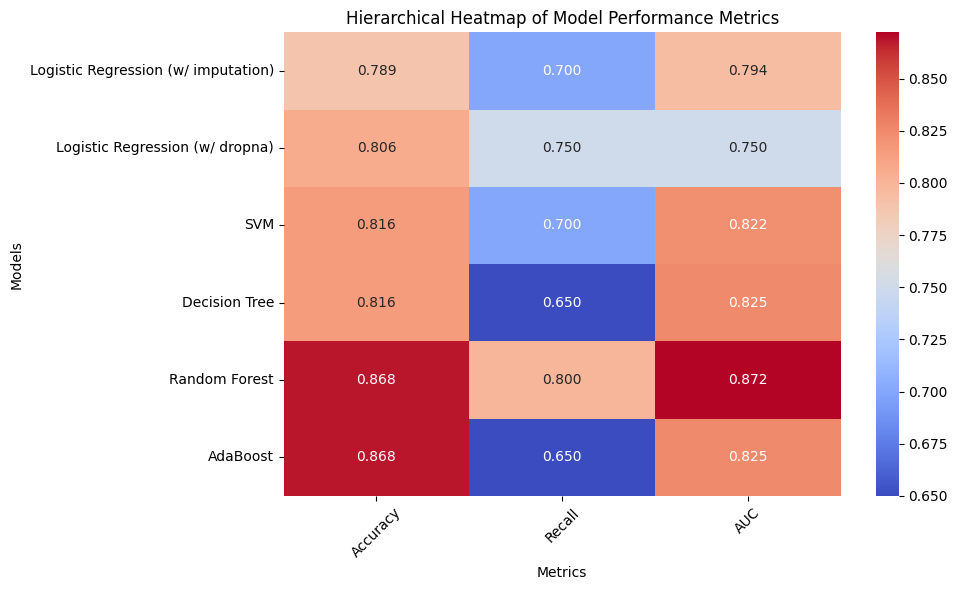

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the hierarchical heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df1, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Hierarchical Heatmap of Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


In [91]:
# Define the sets for the Venn diagram
sets = {
    'Logistic Regression (w/ imputation)': set(['Accuracy', 'Recall', 'AUC']),
    'Logistic Regression (w/ dropna)': set(['Accuracy', 'Recall', 'AUC']),
    'SVM': set(['Accuracy', 'Recall', 'AUC']),
    'Decision Tree': set(['Accuracy', 'Recall', 'AUC']),
    'Random Forest': set(['Accuracy', 'Recall', 'AUC']),
    'AdaBoost': set(['Accuracy', 'Recall', 'AUC'])
}

In [92]:
# Count the number of unique metrics for each model
metrics_counts = {model: len(metrics) for model, metrics in sets.items()}

In [93]:
# Create the Venn diagram subsets based on unique combinations
subsets = {
    '100': metrics_counts['Logistic Regression (w/ imputation)'],
    '010': metrics_counts['Logistic Regression (w/ dropna)'],
    '001': metrics_counts['SVM'],
    '110': metrics_counts['Decision Tree'],
    '101': metrics_counts['Random Forest'],
    '011': metrics_counts['AdaBoost'],
    '111': len(sets['Logistic Regression (w/ imputation)'].intersection(
        sets['Logistic Regression (w/ dropna)'],
        sets['SVM'],
        sets['Decision Tree'],
        sets['Random Forest'],
        sets['AdaBoost']
    ))
}

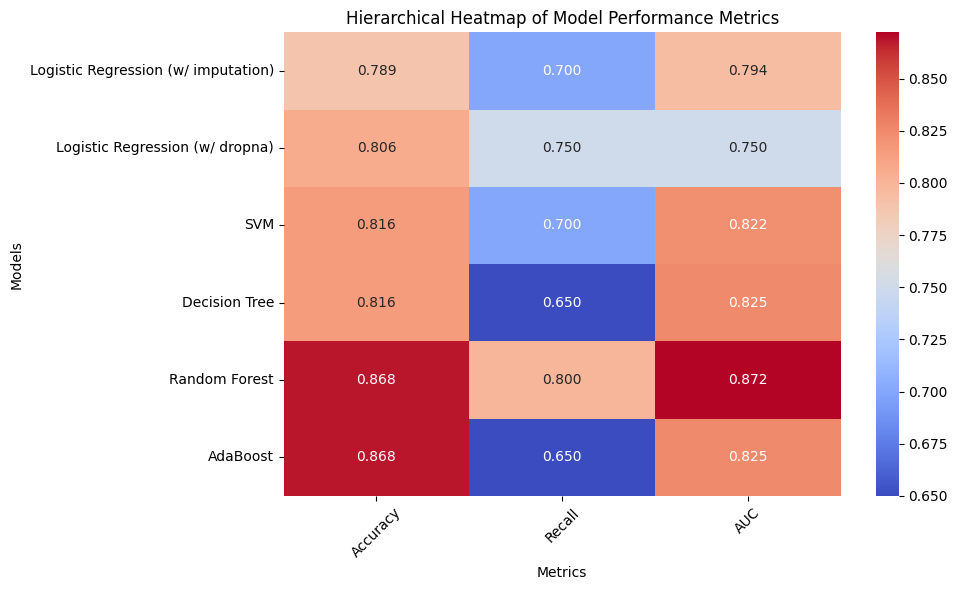

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the hierarchical heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df1, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Hierarchical Heatmap of Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


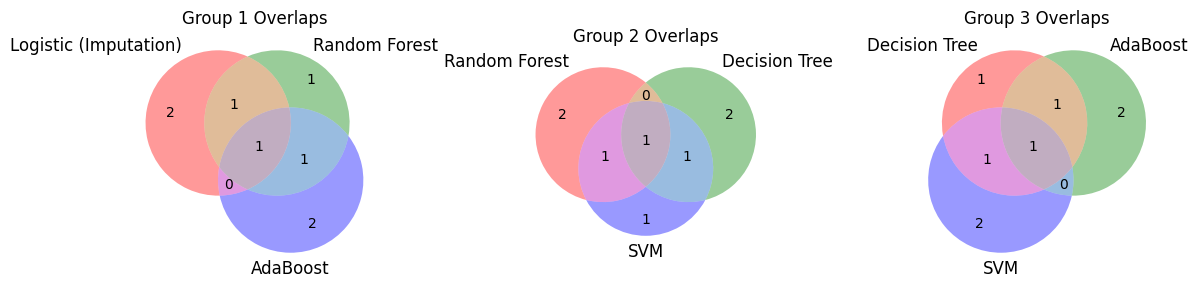

In [128]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Define the subsets for each model
logreg_imputation_metrics = set(["accuracy", "recall", "precision"])
rf_metrics = set(["accuracy", "AUC", "precision"])
dt_metrics = set(["accuracy", "recall", "F1-score"])
adaboost_metrics = set(["accuracy", "AUC", "F1-score"])
svm_metrics = set(["accuracy", "recall", "precision"])

# Function to calculate subsets for venn3
def calculate_subsets(set1, set2, set3):
    set1_set2 = set1.intersection(set2)
    set1_set3 = set1.intersection(set3)
    set2_set3 = set2.intersection(set3)
    set1_set2_set3 = set1.intersection(set2, set3)

    only_set1 = set1 - (set1_set2.union(set1_set3) - set1_set2_set3)
    only_set2 = set2 - (set1_set2.union(set2_set3) - set1_set2_set3)
    only_set3 = set3 - (set1_set3.union(set2_set3) - set1_set2_set3)

    subsets = (
        len(only_set1),
        len(only_set2),
        len(set1_set2 - set1_set2_set3),
        len(only_set3),
        len(set1_set3 - set1_set2_set3),
        len(set2_set3 - set1_set2_set3),
        len(set1_set2_set3),
    )
    return subsets

# Group 1: Logistic Regression (Imputation), Random Forest, AdaBoost
subsets1 = calculate_subsets(logreg_imputation_metrics, rf_metrics, adaboost_metrics)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
venn3(subsets=subsets1, set_labels=('Logistic (Imputation)', 'Random Forest', 'AdaBoost'))
plt.title("Group 1 Overlaps")

# Group 2: Random Forest, Decision Tree, SVM
subsets2 = calculate_subsets(rf_metrics, dt_metrics, svm_metrics)
plt.subplot(1, 3, 2)
venn3(subsets=subsets2, set_labels=('Random Forest', 'Decision Tree', 'SVM'))
plt.title("Group 2 Overlaps")

# Group 3: Decision Tree, AdaBoost, SVM
subsets3 = calculate_subsets(dt_metrics, adaboost_metrics, svm_metrics)
plt.subplot(1, 3, 3)
venn3(subsets=subsets3, set_labels=('Decision Tree', 'AdaBoost', 'SVM'))
plt.title("Group 3 Overlaps")

plt.tight_layout()
plt.show()


SVM Metrics: {'precision', 'accuracy', 'recall'}
Random Forest Metrics: {'precision', 'accuracy', 'AUC'}
Decision Tree Metrics: {'F1-score', 'accuracy', 'recall'}
AdaBoost Metrics: {'F1-score', 'accuracy', 'AUC'}


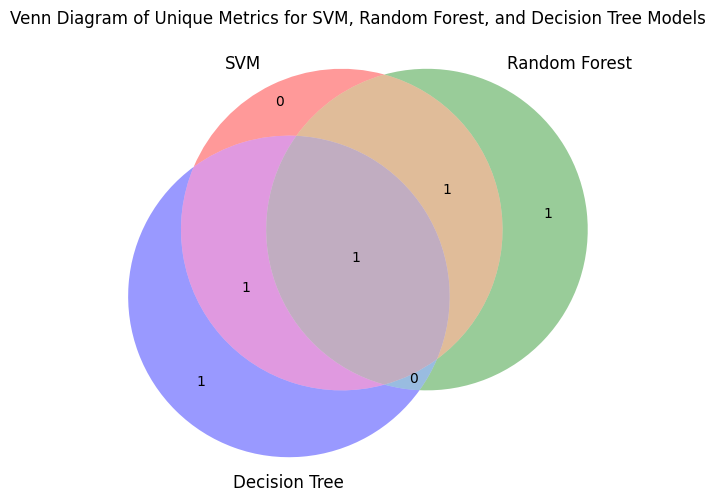

In [106]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Define the subsets for each model
svm_metrics = set(["accuracy", "recall", "precision"])
rf_metrics = set(["accuracy", "AUC", "precision"])
dt_metrics = set(["accuracy", "recall", "F1-score"])
adaboost_metrics = set(["accuracy", "AUC", "F1-score"])

# Verify the subsets
print("SVM Metrics:", svm_metrics)
print("Random Forest Metrics:", rf_metrics)
print("Decision Tree Metrics:", dt_metrics)
print("AdaBoost Metrics:", adaboost_metrics)

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn3(subsets=(svm_metrics, rf_metrics, dt_metrics), set_labels=('SVM', 'Random Forest', 'Decision Tree'))

plt.title("Venn Diagram of Unique Metrics for SVM, Random Forest, and Decision Tree Models")
plt.show()
